In [139]:
import numpy as np
import pandas as pd 
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from feature_engine.encoding import (RareLabelEncoder,MeanEncoder,CountFrequencyEncoder)
from feature_engine.datetime import DatetimeFeatures
from feature_engine.outliers import Winsorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import(
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    StandardScaler,
    PowerTransformer,
    FunctionTransformer
   
)
from sklearn.ensemble import RandomForestRegressor
from feature_engine.selection import SelectBySingleFeaturePerformance
from sklearn.pipeline import Pipeline, FeatureUnion
import warnings

import matplotlib.pyplot as plt


## Display Settings


In [ ]:
pd.set_option("display.max_columns", None)

In [7]:
sklearn.set_config(transform_output = "pandas")

In [8]:
warnings.filterwarnings("ignore")

# Reading Data

In [9]:
train = pd.read_csv(r"/Users/jayantbhatia/Desktop/flight_sagemaker_project/data/training_data.csv")

In [10]:
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-05-15,Kolkata,Banglore,05:50:00,12:30:00,1840,2.0,No Info,12723
1,Jet Airways,2019-05-09,Delhi,Cochin,02:15:00,12:35:00,620,1.0,In-flight meal not included,12373
2,Indigo,2019-06-21,Kolkata,Banglore,21:25:00,00:05:00,160,0.0,No Info,4804
3,Indigo,2019-03-01,Mumbai,Hyderabad,09:10:00,10:40:00,90,0.0,No Info,13999
4,Jet Airways,2019-06-06,Delhi,Cochin,09:40:00,19:00:00,560,2.0,In-flight meal not included,10368
...,...,...,...,...,...,...,...,...,...,...
635,Vistara,2019-06-09,Banglore,Delhi,17:00:00,19:35:00,155,0.0,No Info,4878
636,Jet Airways,2019-05-21,Kolkata,Banglore,20:00:00,08:15:00,735,1.0,In-flight meal not included,10844
637,Indigo,2019-06-21,Banglore,Delhi,06:05:00,08:50:00,165,0.0,No Info,3943
638,Jet Airways,2019-05-03,Banglore,Delhi,08:20:00,11:20:00,180,0.0,No Info,7229


In [11]:
X_train = train.drop(columns = "price")
y_train = train.price.copy()

# Transformation Operation 

## 1. Airline

In [12]:
air_transformer = Pipeline(steps = [
    ("imputer",SimpleImputer(strategy = "most_frequent")),
    ("grouper",RareLabelEncoder(tol = 0.1, replace_with = "other",n_categories= 2)),
    ("encoder",OneHotEncoder(sparse_output = False, handle_unknown= "ignore"))
])

air_transformer.fit_transform(X_train.loc[:,["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_other
0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
635,0.0,0.0,0.0,0.0,1.0
636,0.0,0.0,1.0,0.0,0.0
637,0.0,1.0,0.0,0.0,0.0
638,0.0,0.0,1.0,0.0,0.0


## 2. Date_of_Journey

In [13]:
feature_to_extract = ["month", "week", "day_of_week","day_of_year"]

doj_transformer = Pipeline(steps= [
    ("dt", DatetimeFeatures(features_to_extract = feature_to_extract, yearfirst = True, format = "mixed")),
    ("Scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:,["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.666667,0.647059,0.333333,0.635593
1,0.666667,0.588235,0.500000,0.584746
2,1.000000,0.941176,0.666667,0.949153
3,0.000000,0.000000,0.666667,0.000000
4,1.000000,0.823529,0.500000,0.822034
...,...,...,...,...
635,1.000000,0.823529,1.000000,0.847458
636,0.666667,0.705882,0.166667,0.686441
637,1.000000,0.941176,0.666667,0.949153
638,0.666667,0.529412,0.666667,0.533898


## 3. Source and Destination 

In [14]:
location_subset = X_train.loc[:,["source","destination"]]
location_subset

,source,destination
0,Kolkata,Banglore
1,Delhi,Cochin
2,Kolkata,Banglore
3,Mumbai,Hyderabad
4,Delhi,Cochin
...,...,...
635,Banglore,Delhi
636,Kolkata,Banglore
637,Banglore,Delhi
638,Banglore,Delhi


In [15]:
location_pipe1 = Pipeline(steps = [ 
    ("grouper", RareLabelEncoder(tol= 0.1, replace_with = "other", n_categories = 2)),
    ("mean", MeanEncoder()),
    ("power_transofromer", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,-0.212614,-0.254494
1,1.050610,1.045373
2,-0.212614,-0.254494
3,-1.939682,-0.717876
4,1.050610,1.045373
...,...,...
635,-0.926312,-1.900520
636,-0.212614,-0.254494
637,-0.926312,-1.900520
638,-0.926312,-1.900520


In [16]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [22]:
def is_north(X):
    columns = X.columns.to_list()
    north_cities = ["Delhi","Kolkata","Mumbai","New Delhi"]
    
    return(
        X
        .assign(**{
            f"{col}_is_north": X.loc[:,col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )
FunctionTransformer(func = is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
635,0,1
636,1,0
637,0,1
638,0,1


In [23]:
location_transformer = FeatureUnion(transformer_list= [
    ("part1", location_pipe1),
    ("part2", FunctionTransformer(func = is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,-0.212614,-0.254494,1,0
1,1.050610,1.045373,1,0
2,-0.212614,-0.254494,1,0
3,-1.939682,-0.717876,1,0
4,1.050610,1.045373,1,0
...,...,...,...,...
635,-0.926312,-1.900520,0,1
636,-0.212614,-0.254494,1,0
637,-0.926312,-1.900520,0,1
638,-0.926312,-1.900520,0,1


## 4. Dep_time and Arrival_time

In [28]:
time_subset = X_train.loc[:,["dep_time","arrival_time"]]
time_subset

,dep_time,arrival_time
0,05:50:00,12:30:00
1,02:15:00,12:35:00
2,21:25:00,00:05:00
3,09:10:00,10:40:00
4,09:40:00,19:00:00
...,...,...
635,17:00:00,19:35:00
636,20:00:00,08:15:00
637,06:05:00,08:50:00
638,08:20:00,11:20:00


In [48]:
feature_to_extract = ["hour", "minute"]
time_pipe1 = Pipeline(steps = [ 
    ("dt", DatetimeFeatures(features_to_extract = feature_to_extract)),
    ("Scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.217391,0.909091,0.521739,0.545455
1,0.086957,0.272727,0.521739,0.636364
2,0.913043,0.454545,0.000000,0.090909
3,0.391304,0.181818,0.434783,0.727273
4,0.391304,0.727273,0.826087,0.000000
...,...,...,...,...
635,0.739130,0.000000,0.826087,0.636364
636,0.869565,0.000000,0.347826,0.272727
637,0.260870,0.090909,0.347826,0.909091
638,0.347826,0.363636,0.478261,0.363636


In [49]:
def part_of_day(X, morning = 4, noon = 12, eve= 16, night = 20):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col: pd.to_datetime(X.loc[:,col]).dt.hour
        for col in columns
    })
    
    return (
        X_temp
        .assign(**{
            f"{col}_part_of_day": np.select(
                [X_temp.loc[:,col].between(morning,noon, inclusive = "left"),
                 X_temp.loc[:,col].between(noon,eve, inclusive = "left"),
                 X_temp.loc[:,col].between(eve,night, inclusive = "left")],
                ["morning","noon","eve"],
                default = "night"
            )
            for col in columns
        })
        .drop(columns = columns)
        
    )

FunctionTransformer(func = part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,noon
1,night,noon
2,night,night
3,morning,morning
4,morning,eve
...,...,...
635,eve,eve
636,night,morning
637,morning,morning
638,morning,morning


In [50]:
time_pipe2 = Pipeline(steps = [
    ("part_of_day", FunctionTransformer(func = part_of_day)),
    ("count", CountFrequencyEncoder()),
    ("Scaler", MinMaxScaler())
    
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,0.000000
1,0.207171,0.000000
2,0.207171,1.000000
3,1.000000,0.898734
4,1.000000,0.632911
...,...,...
635,0.290837,0.632911
636,0.207171,0.898734
637,1.000000,0.898734
638,1.000000,0.898734


In [51]:
time_transformer = FeatureUnion(transformer_list= [
    ("part1", time_pipe1),
    ("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.217391,0.909091,0.521739,0.545455,1.000000,0.000000
1,0.086957,0.272727,0.521739,0.636364,0.207171,0.000000
2,0.913043,0.454545,0.000000,0.090909,0.207171,1.000000
3,0.391304,0.181818,0.434783,0.727273,1.000000,0.898734
4,0.391304,0.727273,0.826087,0.000000,1.000000,0.632911
...,...,...,...,...,...,...
635,0.739130,0.000000,0.826087,0.636364,0.290837,0.632911
636,0.869565,0.000000,0.347826,0.272727,0.207171,0.898734
637,0.260870,0.090909,0.347826,0.909091,1.000000,0.898734
638,0.347826,0.363636,0.478261,0.363636,1.000000,0.898734


## 5. Duration

In [54]:
X_train.duration

0      1840
1       620
2       160
3        90
4       560
       ... 
635     155
636     735
637     165
638     180
639     490
Name: duration, Length: 640, dtype: int64

In [99]:
def duration_of_flight(X):
    return (
        X
        .assign(
             duration_cat = np.select(
                [X.duration.lt(180),
                 X.duration.between(180,400, inclusive = "left")],
                ["short","normal"],
                default = "long"
            )
        )
        .drop(columns="duration")
        
    )

FunctionTransformer(func = duration_of_flight).fit_transform(X_train.loc[:, ["duration"]])

,duration_cat
0,long
1,long
2,short
3,short
4,long
...,...
635,short
636,long
637,short
638,normal


In [83]:
class RBFPercentileSmililarity(BaseEstimator, TransformerMixin):
    def __init__(self,variables = None, percentiles = [0.25,0.5,0.75], gamma = 0.1):
        self.variables = variables
        self.percentiles = percentiles
        self.gamma = gamma
        
    def fit(self, X,y= None):
        if not self.variables:
            self.variables = X.select_dtypes(include = "number").columns.to_list()
            
            
        self.reference_values_ = {
            col: (
                X
                .loc[:,col]
                .quantile(self.percentiles)
                .values
                .reshape(-1,1)
            )
            for col in self.variables
        }
        
        return self
    
    def transform(self, X):
        objects = []
        
        for col in self.variables:
            columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
            obj = pd.DataFrame(
                data = rbf_kernel(X.loc[:,[col]], Y = self.reference_values_[col], gamma= self.gamma),
                columns = columns
            )
            objects.append(obj)
        return pd.concat(objects, axis = 1)
        

In [84]:
RBFPercentileSmililarity().fit_transform(X_train.loc[:,["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75
0,0.000000e+00,0.000000e+00,0.0
1,0.000000e+00,1.125982e-278,0.0
2,4.248354e-18,0.000000e+00,0.0
3,0.000000e+00,0.000000e+00,0.0
4,0.000000e+00,4.248354e-18,0.0
...,...,...,...
635,7.187782e-28,0.000000e+00,0.0
636,0.000000e+00,0.000000e+00,0.0
637,1.691898e-10,0.000000e+00,0.0
638,1.000000e+00,0.000000e+00,0.0


In [100]:
duration_pipe1 = Pipeline(steps = [
    ("rbf", RBFPercentileSmililarity()),
    ("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_of_flight)),
	("encoder", OrdinalEncoder(categories=[["short", "normal", "long"]]))
])
duration_union = FeatureUnion(transformer_list = [
    ("part1", duration_pipe1),
    ("part2", duration_pipe2),
    ("part3", FunctionTransformer(func=is_over)),
    ("part4", StandardScaler())
])

duration_transformer = Pipeline(steps = [
    ("outliers", Winsorizer(capping_method = "iqr", fold = 1.5)),
    ("imputer", SimpleImputer(strategy = "median")),
    ("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:,["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.265279,-0.112674,-0.09789,2.0,1,2.452580
1,-0.265279,-0.112674,-0.09789,2.0,0,-0.058483
2,-0.265279,-0.112674,-0.09789,0.0,0,-1.005277
3,-0.265279,-0.112674,-0.09789,0.0,0,-1.149355
4,-0.265279,-0.112674,-0.09789,2.0,0,-0.181978
...,...,...,...,...,...,...
635,-0.265279,-0.112674,-0.09789,0.0,0,-1.015569
636,-0.265279,-0.112674,-0.09789,2.0,0,0.178215
637,-0.265279,-0.112674,-0.09789,0.0,0,-0.994986
638,3.872996,-0.112674,-0.09789,1.0,0,-0.964112


In [86]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

is_over(X_train.loc[:, ["duration"]])

,duration_over_1000
0,1
1,0
2,0
3,0
4,0
...,...
635,0
636,0
637,0
638,0


## 6. Total_stops

In [103]:
X_train.total_stops

0      2.0
1      1.0
2      0.0
3      0.0
4      2.0
      ... 
635    0.0
636    1.0
637    0.0
638    0.0
639    1.0
Name: total_stops, Length: 640, dtype: float64

In [111]:
def is_direct(X):
    return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))
        
total_stop_transformer = Pipeline(steps = [
     ("imputer", SimpleImputer(strategy = "most_frequent")),
     ("direct", FunctionTransformer(func = is_direct))
    
])

total_stop_transformer.fit_transform(X_train.loc[:,["total_stops"]])

,total_stops,is_direct_flight
0,2.0,0
1,1.0,0
2,0.0,1
3,0.0,1
4,2.0,0
...,...,...
635,0.0,1
636,1.0,0
637,0.0,1
638,0.0,1


## 7. Additional info

In [116]:
info_pipe1 = Pipeline(steps = [
    ("group", RareLabelEncoder(tol = 0.1, n_categories = 2,replace_with = "other")),
    ("encoder", OneHotEncoder(handle_unknown = "ignore", sparse_output = False))
])

In [120]:
def have_info(X):
    return X.assign(additional_info = X.additional_info.ne("No Info").astype(int))

In [121]:
info_union = FeatureUnion(transformer_list = [
    ("part1", info_pipe1),
    ("part2", FunctionTransformer(func = have_info))
])

In [122]:
info_transformer = Pipeline(steps = [
    ("imputer",SimpleImputer(strategy = "constant",fill_value = "unknown") ),
    ("union", info_union)
])
info_transformer.fit_transform(X_train.loc[:,["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_other,additional_info
0,0.0,1.0,0.0,0
1,1.0,0.0,0.0,1
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,1.0,0.0,0.0,1
...,...,...,...,...
635,0.0,1.0,0.0,0
636,1.0,0.0,0.0,1
637,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0


# Column Transfomer

In [123]:
column_transformer = ColumnTransformer(transformers = [
    ("air",air_transformer, ['airline']),
    ("date",doj_transformer, ['date_of_journey']),
    ("location",location_transformer,['source','destination']),
    ("time",time_transformer,['dep_time','arrival_time']),
    ("dur", duration_transformer,['duration']),
    ("stop", total_stop_transformer,['total_stops']),
    ("info", info_transformer,['additional_info'])
], remainder = "passthrough")

column_transformer.fit_transform(X_train,y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_other,date__date_of_journey_month,date__date_of_journey_week,date__date_of_journey_day_of_week,date__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stop__total_stops,stop__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_other,info__additional_info
0,1.0,0.0,0.0,0.0,0.0,0.666667,0.647059,0.333333,0.635593,-0.212614,-0.254494,1,0,0.217391,0.909091,0.521739,0.545455,1.000000,0.000000,-0.265279,-0.112674,-0.09789,2.0,1,2.452580,2.0,0,0.0,1.0,0.0,0
1,0.0,0.0,1.0,0.0,0.0,0.666667,0.588235,0.500000,0.584746,1.050610,1.045373,1,0,0.086957,0.272727,0.521739,0.636364,0.207171,0.000000,-0.265279,-0.112674,-0.09789,2.0,0,-0.058483,1.0,0,1.0,0.0,0.0,1
2,0.0,1.0,0.0,0.0,0.0,1.000000,0.941176,0.666667,0.949153,-0.212614,-0.254494,1,0,0.913043,0.454545,0.000000,0.090909,0.207171,1.000000,-0.265279,-0.112674,-0.09789,0.0,0,-1.005277,0.0,1,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.666667,0.000000,-1.939682,-0.717876,1,0,0.391304,0.181818,0.434783,0.727273,1.000000,0.898734,-0.265279,-0.112674,-0.09789,0.0,0,-1.149355,0.0,1,0.0,1.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,1.000000,0.823529,0.500000,0.822034,1.050610,1.045373,1,0,0.391304,0.727273,0.826087,0.000000,1.000000,0.632911,-0.265279,-0.112674,-0.09789,2.0,0,-0.181978,2.0,0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,0.0,0.0,1.0,1.000000,0.823529,1.000000,0.847458,-0.926312,-1.900520,0,1,0.739130,0.000000,0.826087,0.636364,0.290837,0.632911,-0.265279,-0.112674,-0.09789,0.0,0,-1.015569,0.0,1,0.0,1.0,0.0,0
636,0.0,0.0,1.0,0.0,0.0,0.666667,0.705882,0.166667,0.686441,-0.212614,-0.254494,1,0,0.869565,0.000000,0.347826,0.272727,0.207171,0.898734,-0.265279,-0.112674,-0.09789,2.0,0,0.178215,1.0,0,1.0,0.0,0.0,1
637,0.0,1.0,0.0,0.0,0.0,1.000000,0.941176,0.666667,0.949153,-0.926312,-1.900520,0,1,0.260870,0.090909,0.347826,0.909091,1.000000,0.898734,-0.265279,-0.112674,-0.09789,0.0,0,-0.994986,0.0,1,0.0,1.0,0.0,0
638,0.0,0.0,1.0,0.0,0.0,0.666667,0.529412,0.666667,0.533898,-0.926312,-1.900520,0,1,0.347826,0.363636,0.478261,0.363636,1.000000,0.898734,3.872996,-0.112674,-0.09789,1.0,0,-0.964112,0.0,1,0.0,1.0,0.0,0


# feature selection

In [129]:
estimator = RandomForestRegressor(n_estimators = 10, max_depth = 3, random_state = 42)

selector = SelectBySingleFeaturePerformance(
    estimator = estimator,
    scoring = 'r2',
    threshold = 0.1
)

# Putting it all together

In [131]:
preprocessor = Pipeline(steps = [
    ("ctc", column_transformer),
    ("selector", selector)
])
preprocessor.fit_transform(X_train,y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_other,date__date_of_journey_week,date__date_of_journey_day_of_year,location__destination,dur__duration_cat,dur__duration,stop__total_stops,stop__is_direct_flight
0,0.0,0.0,0.0,0.647059,0.635593,-0.254494,2.0,2.452580,2.0,0
1,0.0,1.0,0.0,0.588235,0.584746,1.045373,2.0,-0.058483,1.0,0
2,1.0,0.0,0.0,0.941176,0.949153,-0.254494,0.0,-1.005277,0.0,1
3,1.0,0.0,0.0,0.000000,0.000000,-0.717876,0.0,-1.149355,0.0,1
4,0.0,1.0,0.0,0.823529,0.822034,1.045373,2.0,-0.181978,2.0,0
...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,1.0,0.823529,0.847458,-1.900520,0.0,-1.015569,0.0,1
636,0.0,1.0,0.0,0.705882,0.686441,-0.254494,2.0,0.178215,1.0,0
637,1.0,0.0,0.0,0.941176,0.949153,-1.900520,0.0,-0.994986,0.0,1
638,0.0,1.0,0.0,0.529412,0.533898,-1.900520,1.0,-0.964112,0.0,1


# Visualization

In [132]:
feature_performance = preprocessor.named_steps["selector"].feature_performance_
feature_performance

{'air__airline_Air India': -0.017225249890162164,
 'air__airline_Indigo': 0.10192530907662474,
 'air__airline_Jet Airways': 0.1239411913171421,
 'air__airline_Multiple Carriers': 0.028193887118918386,
 'air__airline_other': 0.1271815711525872,
 'date__date_of_journey_month': 0.0589346912968434,
 'date__date_of_journey_week': 0.19463596346088063,
 'date__date_of_journey_day_of_week': -0.004333513542502739,
 'date__date_of_journey_day_of_year': 0.1952729918684428,
 'location__source': 0.08808177750427153,
 'location__destination': 0.11022581605608621,
 'location__source_is_north': 0.009335212081014102,
 'location__destination_is_north': 0.009335212081014102,
 'time__dep_time_hour': -0.030659726603028774,
 'time__dep_time_minute': -0.005652251377692467,
 'time__arrival_time_hour': 0.021339455898558273,
 'time__arrival_time_minute': 0.03400413105024699,
 'time__dep_time_part_of_day': -0.012479929443142579,
 'time__arrival_time_part_of_day': 0.024773109653535113,
 'dur__duration_rbf_25': 0.

In [134]:
sorted_feat_imp = dict(sorted(feature_performance.items(),key = lambda val: val[1]))
sorted_feat_imp

{'info__additional_info_other': -0.10933988423322138,
 'time__dep_time_hour': -0.030659726603028774,
 'air__airline_Air India': -0.017225249890162164,
 'info__additional_info_No Info': -0.016459399290713606,
 'info__additional_info': -0.016459399290713606,
 'dur__duration_rbf_75': -0.015217440231574933,
 'info__additional_info_In-flight meal not included': -0.013088935217838715,
 'time__dep_time_part_of_day': -0.012479929443142579,
 'time__dep_time_minute': -0.005652251377692467,
 'date__date_of_journey_day_of_week': -0.004333513542502739,
 'dur__duration_rbf_50': 0.003233182815450042,
 'location__source_is_north': 0.009335212081014102,
 'location__destination_is_north': 0.009335212081014102,
 'time__arrival_time_hour': 0.021339455898558273,
 'time__arrival_time_part_of_day': 0.024773109653535113,
 'air__airline_Multiple Carriers': 0.028193887118918386,
 'time__arrival_time_minute': 0.03400413105024699,
 'date__date_of_journey_month': 0.0589346912968434,
 'dur__duration_rbf_25': 0.0739

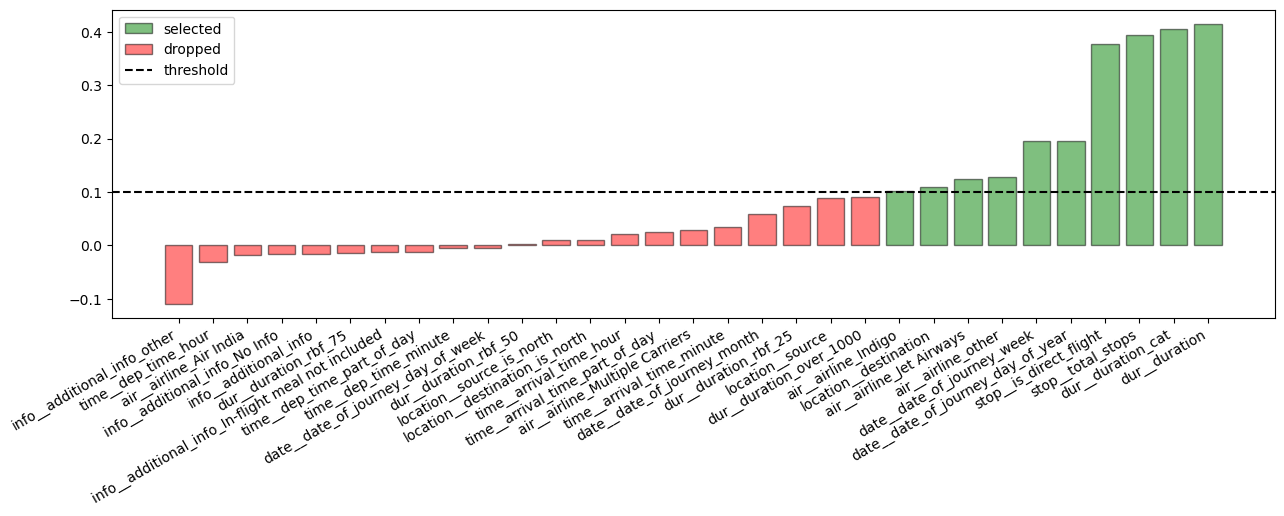

In [143]:
threshold = 0.1

selected_bar = None
dropped_bar = None 
colors = ["red" if score < threshold else "green" for score in sorted_feat_imp.values() ]


fig,ax = plt.subplots(figsize =(15,4))
for i , (feature,score) in enumerate(sorted_feat_imp.items()):
    params = dict(
        x = i,
        height = score,
        edgecolor = "black",
        alpha = 0.5
    )
    
    if score< threshold:
            bar = ax.bar(
                    color = "red",
                    **params
            )
            if not dropped_bar:
                    dropped_bar = bar[0]
            
    else:
            bar = ax.bar(
                    color = "green",
                    **params
            )
            if not selected_bar:
                    selected_bar = bar[0]
                
threshold_line = ax.axhline(
    y= 0.1,
    color = "black",
    linestyle = "--"
    
)

ax.set_xticks(
    ticks = range(len(sorted_feat_imp)),
    labels = list(sorted_feat_imp),
    rotation = 30,
    ha = "right"
)
ax.legend(
    handles = [selected_bar , dropped_bar, threshold_line],
    labels  = ["selected","dropped","threshold"],
    loc = "upper left"
)

plt.show()
            
            
    